# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Resources](#resources)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

In [1]:
#import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

### ToDo 1.1
Read in the `ab_data.csv` data. Store it in `df` and take a look at the top few rows:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
(df.query('converted == 1').shape[0] / (df.user_id.count())) * 100

11.965919355605511

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

**f.** Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values: **treatment & control**, **old_page & new_page**

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df_1 = df.query('group == "treatment" & landing_page == "new_page"')
df_2 = df.query('group == "control" & landing_page == "old_page"')
df2 = df_2.append(df_1)        

In [9]:
# Double Check all of the incorrect rows were removed from df2
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** to answer questions below

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated(keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [12]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
i = df2.query('index == 2893').index
df2 = df2.drop(i)

In [14]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted


### ToDo 1.4  
Use **df2**  to answer the questions below

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [15]:
df2.converted.mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
p1 = df2.query('group == "control"').converted.mean()
p1

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
p2 = df2.query('group == "treatment"').converted.mean()
p2

0.11880806551510564

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p1 - p2
obs_diff

0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [19]:
(df2['landing_page'] == "new_page").mean()

0.50006194422266881

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

> The overall conversion rate of users regardless of the page they received is 11.96%. The proportion of users converted for control group is 12.03% while the proportion of users converted for treatment group is 11.88%. There is little significant difference between these valuues and this shows that the new treatment group users did not lead to more conversions

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?

$$H_0 : p_{new} \leq p_{old} $$

$$H_1 : p_{new} > p_{old}  $$

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [22]:
n_new = (len(df2.query('landing_page == "new_page"')))
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = (len(df2.query('landing_page == "old_page"')))
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.

In [24]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1,0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.11987475053334251

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [25]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1,0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted.mean()

0.12028305133747264

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [26]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

-0.00040830080413012393


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [30]:
# Sampling distribution 
p_diffs = []
for _ in range (10000):
    new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
    old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart. 

In [31]:
new_converted = df2.query('landing_page =="new_page"').converted.mean()
old_converted = df2.query('landing_page =="old_page"').converted.mean()
obs_diff = new_converted - old_converted
obs_diff

-0.0015782389853555567

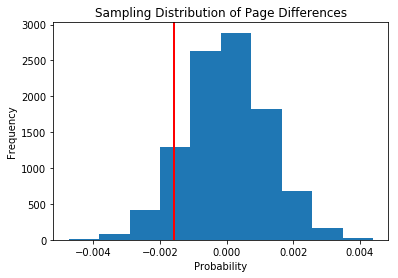

In [32]:
p_diffs = np.array(p_diffs)    
plt.hist(p_diffs);
plt.axvline(obs_diff, color='red', linewidth=2);
plt.title('Sampling Distribution of Page Differences');
plt.xlabel('Probability');
plt.ylabel('Frequency');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [33]:
(p_diffs > obs_diff).mean()

0.90310000000000001

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? 

> This value is known as the p-value. A small p-value suggests that we reject th null hypothesis. This value, 0.9 is greater than the Type 1 error rate(0.05), this suggests that our statistics was likely to come from the null hypothesis. Therefore, we do not have evidence to reject the null. This signifies that the new pages conversion is lesser than or equal to the conversion rate of old pages. 



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [34]:
#import libraries
import statsmodels.api as sm

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [35]:
# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page"').converted.value_counts()[1]
convert_old

17489

In [36]:
# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page"').converted.value_counts()[1]
convert_new

17264

In [37]:
# number of individuals who were shown the old_page
n_old = (len(df2.query('landing_page == "old_page"')))
n_old

145274

In [38]:
# number of individuals who received new_page
n_new =  (len(df2.query('landing_page == "new_page"')))
n_new

145310

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

In [40]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

> The z-score(1.31) is less than critical value of 1.645 at 95% confidence interval, since it is a one-tailed test. The z-score lies in the rejection region and therefore we fail to reject the null hyothesis. This p-value is the similar to the value computed earlier, which agrees to previous findings.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>Logistic regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [41]:
#dummy variables
df2['intercept']=1
df2['ab_page']= pd.get_dummies(df2['group'])['treatment']

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [42]:
#instantiate logistic regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [43]:
#fit the model
results = logit_mod.fit()

#get summary statistics
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-11 13:17 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

$$H_0 : p_{new} = p_{old} $$

$$H_1 : p_{new} \neq p_{old}  $$

>- In Part II, for the null hypothesis, we assumed that the conversion of new pages is lesser than or equal to the conversion of old pages and the alternative hypothesis, the conversion of new pages is greater than the old. The hypotheses are one-sided.

>- Here, for the null hypothesis, we assume that the conversion of new pages is the same to that of old pages. For the alternative hypothesis, we try to prove that the conversion of new pages is different from the conversion of old pages. The hypotheses are two-sided.

>- The p_value associated with ab_page is 0.1899 which is different from the previous value because this is a two-tailed test. the p-value 0.1899 is greater than the critical error rate of 0.05, which suggests that we do not have evidence to reject the null hypothesis.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> Individuals may be affected by the novelty effect and aversion effect, thereby bias to old pages and new pages models which might influence whether they convert or not. Other factors can be considered such as location, duration spent on the page and age group of the individual.

> There are disadvantages of additional terms, in some cases, not all variables added affect the outcome of the model.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [44]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [45]:
# Join with the df2 dataframe
df_merged = df2.merge(df_countries, on='user_id', how='inner')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US


In [46]:
# Create the necessary dummy variables
df_merged['intercept']=1
df_merged[['UK', 'US', 'CA']]= pd.get_dummies(df_merged['country'])

In [47]:
#instantiate logistic regression model
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'US', 'CA']])

In [48]:
#fit the model
results = log_mod.fit()

#get summary statistics
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-11 13:18 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
CA             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 

Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

> - Individuals from the US and CA have 5% and 4% rate of conversion respectively.
The statistics show that that the p-values for US and CA as 0.07 and 0.12 respectively. These values computed are greater the critical value of 0.05, this shows that we fail to reject the null hypothesis. 
- The coversion rate of country multiplied by ab_page shows 7% and 4% for US and CA respectively. The effect of country and page to predict the conversion rate shows an insignificant difference

In [49]:
# Fit your model, and summarize the results
df_merged['UK_ab_page'] = df_merged['UK']*df_merged['ab_page']
df_merged['US_ab_page'] = df_merged['US']*df_merged['ab_page']
df_merged['CA_ab_page'] = df_merged['CA']*df_merged['ab_page']
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,CA,UK_ab_page,US_ab_page,CA_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1,0,0,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1,0,0,0


In [50]:
#instantiate logistic regression model
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page','US', 'CA', 'US_ab_page', 'CA_ab_page']])

In [51]:
#fit the model
results = log_mod.fit()

#get summary statistics
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-11 13:19 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
CA             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
US_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
CA_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

## Conclusion

>All the statistics conducted do not provide a value less than the critical value of 0.05. We therefore have no evidence to reject the null hypothesis. This proves that implementing the new page will not have a significant effect. We suggest that the old page be retained while features on the new page is still being improved on.

<a id='finalcheck'></a>
## Resources

https://stackoverflow.com/questions/43136137/drop-a-specific-row-in-pandas

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0